In [93]:
!pip install -q hdbscan bertopic sentence-transformers umap-learn wordcloud
!pip install -q umap-learn wordcloud sentence-transformers bertopic hdbscan

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
import umap.umap_ as umap

!pip install bertopic
import hdbscan
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

In [94]:
# reproducibility
RSEED = 42

In [95]:
# PATHS + LOAD DATA
INPUT_CSV = "/content/drive/MyDrive/clustering/ruangguru_preprocessed_fix_bgt.csv"
OUTPUT_CSV = "/content/hasil_clustering_kmeans_lda.csv"
try:
    df = pd.read_csv(INPUT_CSV)
except pd.errors.ParserError as e:
    print(f"ParserError encountered: {e}. Trying with sep=';'")
    df = pd.read_csv(INPUT_CSV, sep=';')

if 'Column2' in df.columns and 'cleaned_text' not in df.columns:
    df = df.rename(columns={'Column2': 'cleaned_text'})

if "cleaned_text" not in df.columns:
    raise ValueError("Dataset harus punya kolom 'cleaned_text'.")
texts = df["cleaned_text"].astype(str).tolist()

In [96]:
# VECTORIZATION
# - TF-IDF untuk clustering KMeans
# - CountVectorizer untuk LDA (topic modeling)

tfidf = TfidfVectorizer(max_features=4000, stop_words=None, ngram_range=(1,1))
X_tfidf = tfidf.fit_transform(texts)
feature_names_tfidf = tfidf.get_feature_names_out()

count_vec = CountVectorizer(max_features=4000, stop_words=None, ngram_range=(1,1))
X_counts = count_vec.fit_transform(texts)
feature_names_count = count_vec.get_feature_names_out()

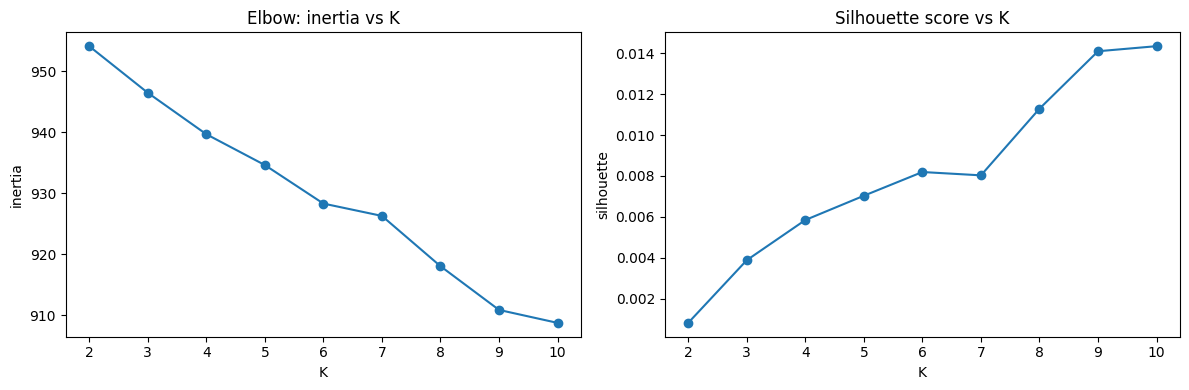

Rekomendasi K (berdasarkan silhouette): 10


In [97]:
# MENENTUKAN K UNTUK K-MEANS
#    - Elbow (inertia) & Silhouette (2..max_k)

from tqdm import tqdm
max_k = 10
inertias = []
sil_scores = []
Ks = list(range(2, max_k+1))
for k in Ks:
    km = MiniBatchKMeans(n_clusters=k, random_state=RSEED, batch_size=1024)
    km.fit(X_tfidf)
    inertias.append(km.inertia_)
    try:
        sil = silhouette_score(X_tfidf, km.labels_)
    except:
        sil = None
    sil_scores.append(sil)

# Plot Elbow + Silhouette
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(Ks, inertias, marker='o')
plt.title("Elbow: inertia vs K")
plt.xlabel("K")
plt.ylabel("inertia")

plt.subplot(1,2,2)
plt.plot(Ks, [s if s is not None else np.nan for s in sil_scores], marker='o')
plt.title("Silhouette score vs K")
plt.xlabel("K")
plt.ylabel("silhouette")
plt.tight_layout()
plt.show()

# Pilihan default K: ambil K dengan silhouette tertinggi (fallback = 5)
best_idx = np.nanargmax([s if s is not None else -999 for s in sil_scores])
best_k = Ks[best_idx] if sil_scores[best_idx] is not None else 5
print(f"Rekomendasi K (berdasarkan silhouette): {best_k}")

In [98]:
def explain_elbow(Ks, inertias):
    print("\n=== PENJELASAN ELBOW METHOD ===")
    diffs = np.diff(inertias)
    elbow_k = Ks[np.argmin(np.abs(diffs))]

    print(
        "Grafik Elbow menunjukkan hubungan antara jumlah cluster (K) "
        "dengan nilai inertia yang merepresentasikan tingkat kekompakan cluster."
    )
    print(
        "Nilai inertia terus menurun seiring bertambahnya K, "
        "menandakan bahwa penambahan cluster meningkatkan kekompakan data."
    )
    print(
        f"Namun, tidak terlihat titik siku yang sangat tajam. "
        f"Perubahan penurunan inertia mulai melandai sekitar K = {elbow_k}, "
        "sehingga pemilihan K perlu dikonfirmasi menggunakan metrik lain."
    )

explain_elbow(Ks, inertias)


=== PENJELASAN ELBOW METHOD ===
Grafik Elbow menunjukkan hubungan antara jumlah cluster (K) dengan nilai inertia yang merepresentasikan tingkat kekompakan cluster.
Nilai inertia terus menurun seiring bertambahnya K, menandakan bahwa penambahan cluster meningkatkan kekompakan data.
Namun, tidak terlihat titik siku yang sangat tajam. Perubahan penurunan inertia mulai melandai sekitar K = 6, sehingga pemilihan K perlu dikonfirmasi menggunakan metrik lain.


In [99]:
def explain_silhouette(Ks, sil_scores):
    best_k = Ks[np.nanargmax(sil_scores)]
    best_score = np.nanmax(sil_scores)

    print("\n=== PENJELASAN SILHOUETTE SCORE ===")
    print(
        "Silhouette Score digunakan untuk mengukur kualitas pemisahan antar cluster, "
        "di mana nilai yang lebih tinggi menunjukkan cluster yang lebih terpisah dengan baik."
    )
    print(
        f"Berdasarkan grafik, nilai silhouette tertinggi diperoleh pada K = {best_k} "
        f"dengan skor sebesar {best_score:.4f}."
    )
    print(
        "Meskipun nilai silhouette relatif kecil, hal ini umum terjadi pada clustering teks "
        "berdimensi tinggi yang memiliki kemiripan semantik antar dokumen."
    )
    print(
        f"Oleh karena itu, K = {best_k} dipilih sebagai jumlah cluster optimal."
    )

explain_silhouette(Ks, sil_scores)


=== PENJELASAN SILHOUETTE SCORE ===
Silhouette Score digunakan untuk mengukur kualitas pemisahan antar cluster, di mana nilai yang lebih tinggi menunjukkan cluster yang lebih terpisah dengan baik.
Berdasarkan grafik, nilai silhouette tertinggi diperoleh pada K = 10 dengan skor sebesar 0.0143.
Meskipun nilai silhouette relatif kecil, hal ini umum terjadi pada clustering teks berdimensi tinggi yang memiliki kemiripan semantik antar dokumen.
Oleh karena itu, K = 10 dipilih sebagai jumlah cluster optimal.


In [100]:
# RUN K-MEANS (final)

K_FINAL = best_k
kmeans = KMeans(n_clusters=K_FINAL, random_state=RSEED, n_init=20)
k_labels = kmeans.fit_predict(X_tfidf)
df["kmeans_cluster"] = k_labels

# Metrics
try:
    k_sil = float(silhouette_score(X_tfidf, k_labels))
    k_db = float(davies_bouldin_score(X_tfidf.toarray(), k_labels))
except:
    k_sil = k_db = None
print(f"KMeans: n_clusters={K_FINAL}, silhouette={k_sil}, davies_bouldin={k_db}")

KMeans: n_clusters=10, silhouette=0.01544347131891356, davies_bouldin=5.913392578279861


In [101]:
def explain_kmeans_metrics(n_clusters, silhouette, davies_bouldin):
    print("\n=== INTERPRETASI METRIK K-MEANS ===")

    print(f"Jumlah cluster yang digunakan adalah {n_clusters}.")

    if silhouette < 0.05:
        sil_text = (
            "Nilai silhouette tergolong rendah, yang menunjukkan bahwa "
            "pemisahan antar cluster masih lemah dan terdapat kemiripan "
            "konten antar dokumen di cluster yang berbeda."
        )
    elif silhouette < 0.25:
        sil_text = (
            "Nilai silhouette berada pada tingkat sedang, yang menunjukkan "
            "adanya pemisahan cluster namun belum sepenuhnya optimal."
        )
    else:
        sil_text = (
            "Nilai silhouette cukup tinggi, yang menunjukkan pemisahan "
            "cluster yang baik."
        )

    print(f"Silhouette Score = {silhouette:.4f}. {sil_text}")

    if davies_bouldin > 3:
        db_text = (
            "Nilai Davies-Bouldin Index relatif tinggi, yang mengindikasikan "
            "adanya tumpang tindih antar cluster."
        )
    else:
        db_text = (
            "Nilai Davies-Bouldin Index relatif rendah, yang menunjukkan "
            "cluster yang cukup terpisah."
        )

    print(f"Davies-Bouldin Index = {davies_bouldin:.4f}. {db_text}")

    print(
        "Meskipun demikian, jumlah cluster ini dipilih karena memberikan "
        "nilai evaluasi terbaik dibandingkan jumlah cluster lainnya "
        "pada percobaan yang dilakukan."
    )

explain_kmeans_metrics(K_FINAL, k_sil, k_db)



=== INTERPRETASI METRIK K-MEANS ===
Jumlah cluster yang digunakan adalah 10.
Silhouette Score = 0.0154. Nilai silhouette tergolong rendah, yang menunjukkan bahwa pemisahan antar cluster masih lemah dan terdapat kemiripan konten antar dokumen di cluster yang berbeda.
Davies-Bouldin Index = 5.9134. Nilai Davies-Bouldin Index relatif tinggi, yang mengindikasikan adanya tumpang tindih antar cluster.
Meskipun demikian, jumlah cluster ini dipilih karena memberikan nilai evaluasi terbaik dibandingkan jumlah cluster lainnya pada percobaan yang dilakukan.


In [102]:
# TOP WORDS PER K-MEANS CLUSTER

def top_terms_per_cluster(km_model, vectorizer, n_terms=12):
    terms = vectorizer.get_feature_names_out()
    order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
    cluster_top_terms = {}
    for i in range(km_model.n_clusters):
        top = [terms[ind] for ind in order_centroids[i, :n_terms]]
        cluster_top_terms[i] = top
    return cluster_top_terms

k_top_terms = top_terms_per_cluster(kmeans, tfidf, n_terms=12)
print("\nTop words per KMeans cluster:")
for c, words in k_top_terms.items():
    print(f"Cluster {c}: {', '.join(words)}")


Top words per KMeans cluster:
Cluster 0: harap, layan, notifikasi, pesan, kirim, catat, nomor, terkadang, deteksi, mogok, habis, langgan
Cluster 1: bayar, gratis, mahal, langgan, orang, paket, kecewa, iklan, pintar, duit, dunia, layan
Cluster 2: tingkat, bosan, matematika, cocok, kuis, tarik, cepat, bahasa, contoh, pintar, pilih, daftar
Cluster 3: rangkum, saran, bosan, tulis, resolusi, kuis, fisika, sukses, konsep, kilat, layar, subtitle
Cluster 4: buka, error, jaring, sistem, sinyal, tulis, lancar, lihat, topik, loading, muncul, wifi
Cluster 5: seru, kuis, rekomendasi, langgan, mantap, main, tingkat, bosan, tarik, efektif, bimbel, sesuai
Cluster 6: manfaat, siswa, cocok, proses, buka, ilmu, harap, lihat, detail, tarik, komplit, freeze
Cluster 7: anak, pintar, wajib, sistem, siswa, tarik, indonesia, tema, detail, baca, kuis, tunjang
Cluster 8: gampang, sesuai, bosan, seru, super, hasil, saran, ngantuk, asik, ribet, sangaat, salah
Cluster 9: langgan, paket, gratis, mahal, buka, lihat,

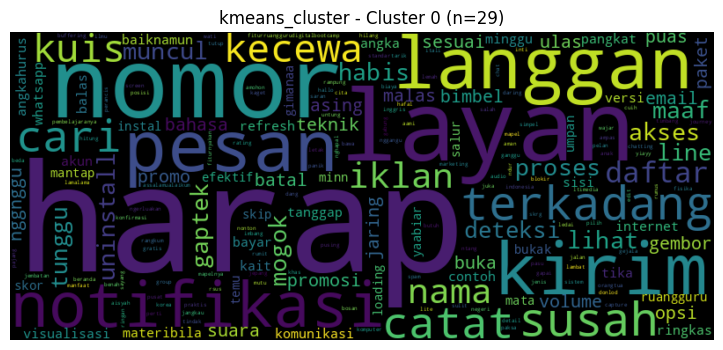

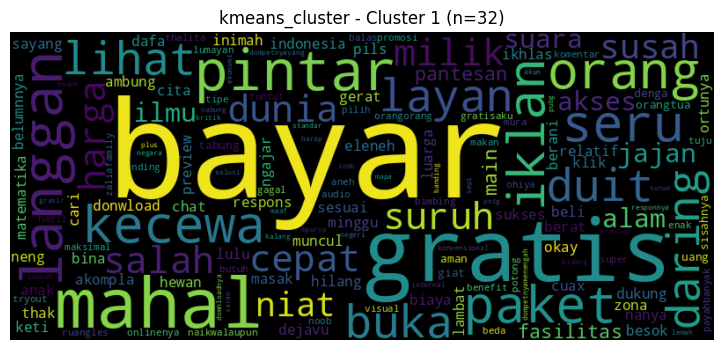

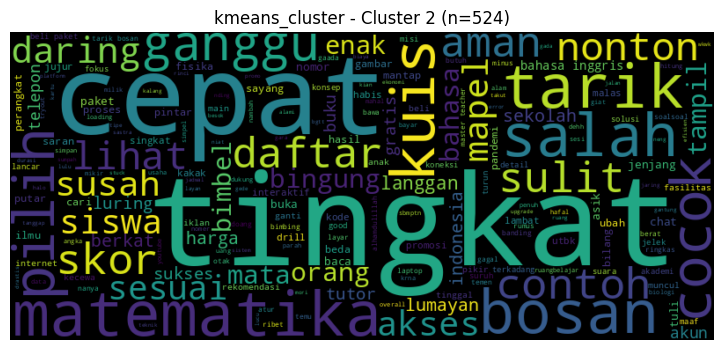

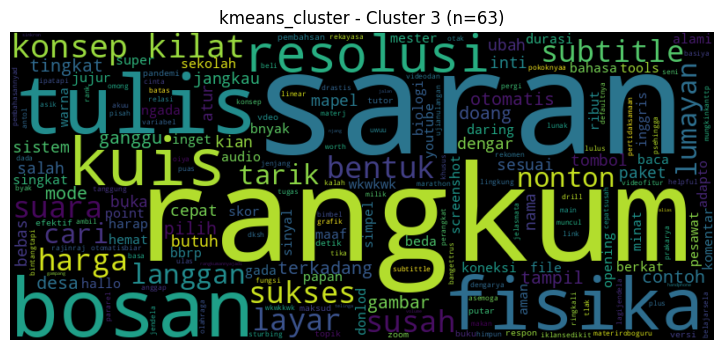

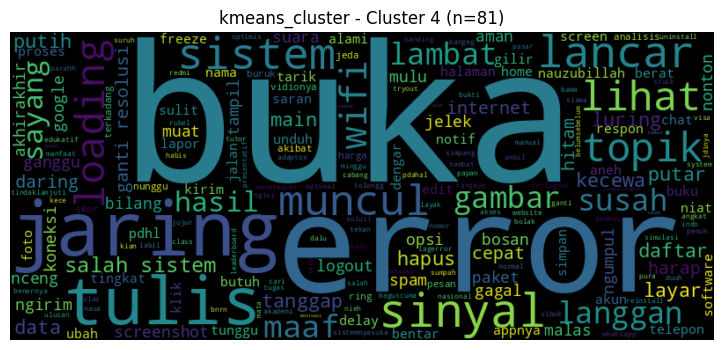

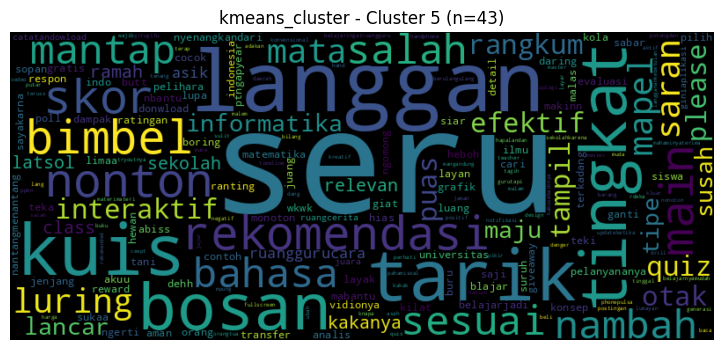

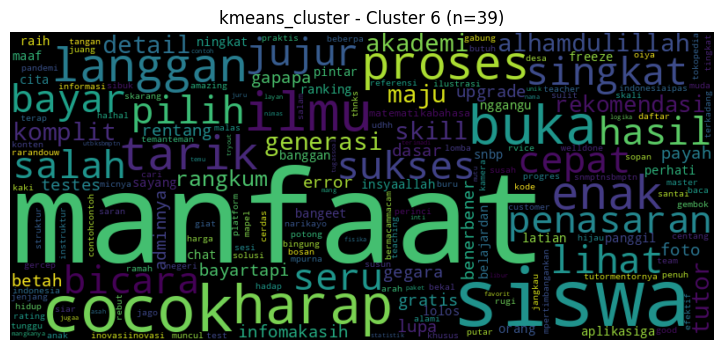

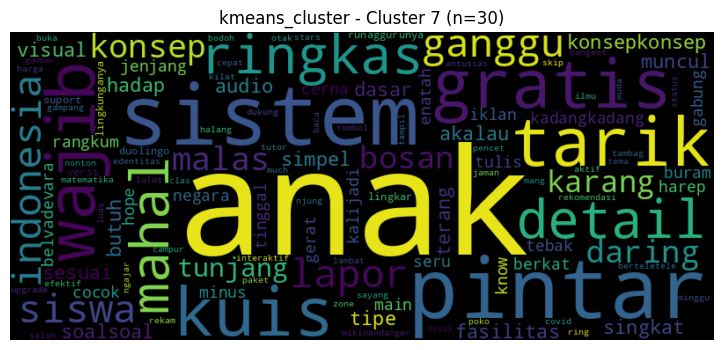

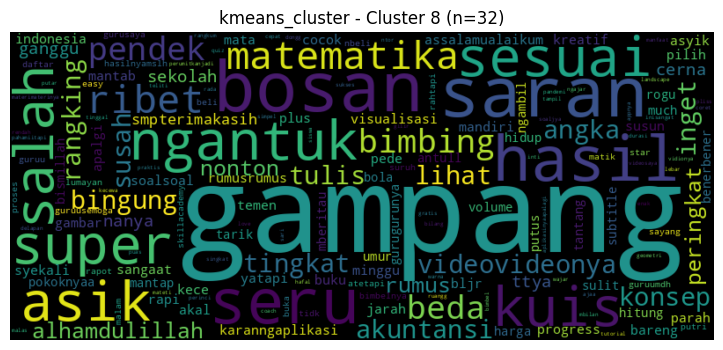

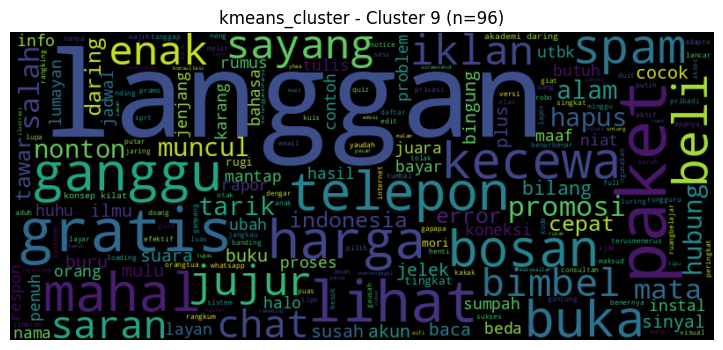

In [103]:

# WORDCLOUD per cluster (KMeans)

def show_wordclouds_for_labels(df, label_col, text_col="cleaned_text", max_clusters=12):
    clusters = sorted(df[label_col].unique())
    clusters = clusters[:max_clusters]
    for c in clusters:
        txt = " ".join(df[df[label_col]==c][text_col].astype(str).tolist())
        if len(txt.strip()) < 20:
            continue
        wc = WordCloud(width=800, height=350).generate(txt)
        plt.figure(figsize=(10,4))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{label_col} - Cluster {c} (n={len(df[df[label_col]==c])})")
        plt.show()

show_wordclouds_for_labels(df, "kmeans_cluster")

In [104]:
# TOPIC MODELING (LDA) menggunakan CountVectorizer

N_TOPICS = 10  # ubah bila perlu
lda = LatentDirichletAllocation(n_components=N_TOPICS, random_state=RSEED, learning_method='online', max_iter=10)
lda.fit(X_counts)

def lda_top_words(model, feature_names, n_top_words=12):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics.append((topic_idx, top_features))
    return topics

lda_topics = lda_top_words(lda, feature_names_count, n_top_words=12)
print("\nLDA topics (top words):")
for tid, words in lda_topics:
    print(f"Topic {tid}: {', '.join(words)}")

# Transform documents to topic distribution and assign dominant topic
doc_topic_distr = lda.transform(X_counts)
doc_topic = doc_topic_distr.argmax(axis=1)
df["lda_topic"] = doc_topic


LDA topics (top words):
Topic 0: salah, malas, asik, tampil, promosi, mantap, seru, tulis, laptop, hasil, hapus, sistem
Topic 1: gampang, seru, bayar, beda, bimbing, alhamdulillah, sulit, lumayan, beli, cocok, tuju, susun
Topic 2: iklan, anak, enak, pintar, ganggu, orang, skip, bilang, minus, detik, maaf, overall
Topic 3: langgan, saran, bosan, tarik, rangkum, bahasa, kuis, skor, matematika, gratis, susah, contoh
Topic 4: nonton, uang, baca, orangtua, internal, besok, tumbal, muncul, ruangbaca, cepat, daring, hilang
Topic 5: langgan, lihat, chat, error, nomor, telepon, daring, spam, daftar, paket, ganggu, konsep
Topic 6: harga, mahal, bimbel, lumayan, gratis, paket, gambar, potong, fasilitas, jangkau, promo, fokus
Topic 7: buka, tingkat, langgan, jaring, muncul, lancar, daftar, tulis, cepat, layar, putar, main
Topic 8: ilmu, akses, layan, proses, bayar, cari, lambat, kartu, manfaat, platform, skill, internet
Topic 9: siswa, puas, ilmu, jujur, manfaat, nambah, nding, otak, sukses, saya

In [105]:
# 8. METRICS for LDA assignment (using TF-IDF embeddings or counts)

try:
    lda_sil = float(silhouette_score(X_tfidf, df["lda_topic"]))
    lda_db = float(davies_bouldin_score(X_tfidf.toarray(), df["lda_topic"]))
except:
    lda_sil = lda_db = None
print(f"LDA assigned topics -> silhouette({lda_sil}), davies_bouldin({lda_db})")

LDA assigned topics -> silhouette(0.0026925182860572804), davies_bouldin(9.20134326083456)


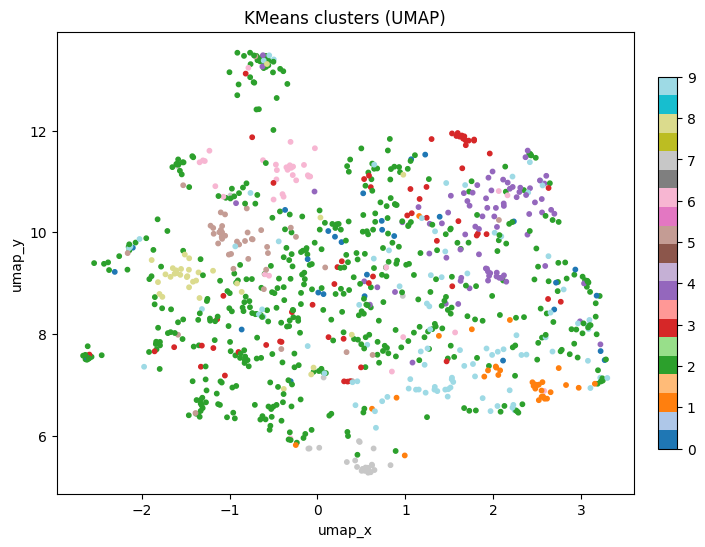

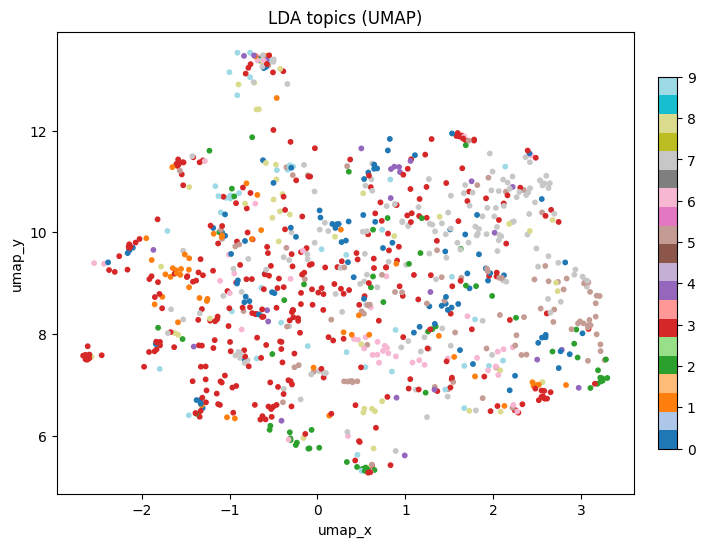

In [106]:
# 9. VISUALISASI UMAP + SCATTER

reducer = umap.UMAP(n_components=2, random_state=RSEED, n_neighbors=15, min_dist=0.1)
X_embed_2d = reducer.fit_transform(X_tfidf)

df["umap_x"] = X_embed_2d[:,0]
df["umap_y"] = X_embed_2d[:,1]

def plot_clusters_2d(df, x, y, label_col, title):
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(df[x], df[y], c=df[label_col], s=10, cmap="tab20")
    plt.title(title)
    plt.xlabel(x); plt.ylabel(y)
    plt.colorbar(scatter, fraction=0.03, pad=0.04)
    plt.show()

plot_clusters_2d(df, "umap_x", "umap_y", "kmeans_cluster", "KMeans clusters (UMAP)")
plot_clusters_2d(df, "umap_x", "umap_y", "lda_topic", "LDA topics (UMAP)")


In [107]:
def explain_umap_kmeans(df, cluster_col='kmeans_cluster'):
    print("\n=== PENJELASAN VISUALISASI K-MEANS (UMAP) ===")
    print(
        "Visualisasi ini menampilkan hasil clustering K-Means yang direduksi ke dua dimensi "
        "menggunakan metode UMAP."
    )

    cluster_sizes = df[cluster_col].value_counts().sort_index()
    for c, n in cluster_sizes.items():
        print(f"Cluster {c} terdiri dari {n} dokumen.")

    print(
        "Terlihat bahwa beberapa cluster membentuk kelompok yang relatif padat dan terpisah, "
        "sementara sebagian lainnya masih saling tumpang tindih."
    )
    print(
        "Hal ini menunjukkan bahwa sebagian tema dokumen memiliki perbedaan yang cukup jelas, "
        "sedangkan tema lainnya memiliki kemiripan konten."
    )
    print(
        "Perlu dicatat bahwa UMAP hanya digunakan untuk visualisasi dan tidak memengaruhi "
        "hasil clustering."
    )

explain_umap_kmeans(df)


=== PENJELASAN VISUALISASI K-MEANS (UMAP) ===
Visualisasi ini menampilkan hasil clustering K-Means yang direduksi ke dua dimensi menggunakan metode UMAP.
Cluster 0 terdiri dari 29 dokumen.
Cluster 1 terdiri dari 32 dokumen.
Cluster 2 terdiri dari 524 dokumen.
Cluster 3 terdiri dari 63 dokumen.
Cluster 4 terdiri dari 81 dokumen.
Cluster 5 terdiri dari 43 dokumen.
Cluster 6 terdiri dari 39 dokumen.
Cluster 7 terdiri dari 30 dokumen.
Cluster 8 terdiri dari 32 dokumen.
Cluster 9 terdiri dari 96 dokumen.
Terlihat bahwa beberapa cluster membentuk kelompok yang relatif padat dan terpisah, sementara sebagian lainnya masih saling tumpang tindih.
Hal ini menunjukkan bahwa sebagian tema dokumen memiliki perbedaan yang cukup jelas, sedangkan tema lainnya memiliki kemiripan konten.
Perlu dicatat bahwa UMAP hanya digunakan untuk visualisasi dan tidak memengaruhi hasil clustering.


In [108]:
def explain_umap_lda(df, topic_col='lda_topic'):
    print("\n=== PENJELASAN VISUALISASI TOPIK LDA (UMAP) ===")
    print(
        "Visualisasi ini menunjukkan distribusi dokumen berdasarkan topik dominan "
        "hasil pemodelan LDA."
    )

    topic_sizes = df[topic_col].value_counts().sort_index()
    for t, n in topic_sizes.items():
        print(f"Topik {t} muncul pada {n} dokumen.")

    print(
        "Distribusi titik pada visualisasi LDA terlihat lebih menyebar dan saling tumpang tindih."
    )
    print(
        "Hal ini disebabkan oleh sifat LDA sebagai metode soft clustering, "
        "di mana satu dokumen dapat memiliki keterkaitan dengan lebih dari satu topik."
    )
    print(
        "Dengan demikian, visualisasi ini merepresentasikan keterkaitan tema "
        "antar dokumen, bukan pemisahan cluster secara tegas."
    )

explain_umap_lda(df)


=== PENJELASAN VISUALISASI TOPIK LDA (UMAP) ===
Visualisasi ini menunjukkan distribusi dokumen berdasarkan topik dominan hasil pemodelan LDA.
Topik 0 muncul pada 95 dokumen.
Topik 1 muncul pada 50 dokumen.
Topik 2 muncul pada 66 dokumen.
Topik 3 muncul pada 332 dokumen.
Topik 4 muncul pada 27 dokumen.
Topik 5 muncul pada 95 dokumen.
Topik 6 muncul pada 51 dokumen.
Topik 7 muncul pada 159 dokumen.
Topik 8 muncul pada 48 dokumen.
Topik 9 muncul pada 46 dokumen.
Distribusi titik pada visualisasi LDA terlihat lebih menyebar dan saling tumpang tindih.
Hal ini disebabkan oleh sifat LDA sebagai metode soft clustering, di mana satu dokumen dapat memiliki keterkaitan dengan lebih dari satu topik.
Dengan demikian, visualisasi ini merepresentasikan keterkaitan tema antar dokumen, bukan pemisahan cluster secara tegas.


In [109]:
# INTERPRETASI OTOMATIS: top words per cluster/topic (bag-of-words freq)

def auto_interpret(df, label_col, text_col="cleaned_text", top_n=15):
    print(f"\n=== Interpretasi {label_col} ===")
    for c in sorted(df[label_col].unique()):
        texts = df[df[label_col]==c][text_col].astype(str).tolist()
        words = " ".join(texts).split()
        top = Counter(words).most_common(top_n)
        top_words = ", ".join([w for w,_ in top])
        print(f"{label_col} {c} (n={len(texts)}): {top_words}")

auto_interpret(df, "kmeans_cluster")
auto_interpret(df, "lda_topic")


=== Interpretasi kmeans_cluster ===
kmeans_cluster 0 (n=29): harap, layan, nomor, langgan, kirim, pesan, notifikasi, terkadang, susah, catat, cari, kuis, kecewa, iklan, nama
kmeans_cluster 1 (n=32): bayar, gratis, mahal, langgan, pintar, iklan, kecewa, seru, orang, paket, daring, layan, buka, lihat, duit
kmeans_cluster 2 (n=524): tingkat, tarik, bosan, cepat, matematika, bahasa, kuis, salah, pilih, daftar, cocok, ganggu, contoh, skor, sulit
kmeans_cluster 3 (n=63): saran, rangkum, bosan, tulis, konsep, fisika, kuis, kilat, resolusi, subtitle, susah, suara, harga, sukses, bentuk
kmeans_cluster 4 (n=81): buka, error, jaring, sistem, tulis, sinyal, lancar, muncul, loading, lihat, topik, wifi, maaf, salah, langgan
kmeans_cluster 5 (n=43): seru, langgan, tarik, kuis, tingkat, bosan, rekomendasi, nonton, main, bimbel, skor, sesuai, mantap, bahasa, salah
kmeans_cluster 6 (n=39): manfaat, siswa, cocok, buka, ilmu, harap, proses, langgan, enak, tarik, bayar, singkat, sukses, penasaran, hasil
k

In [110]:
# INTERPRETASI OTOMATIS

def interpretasi(df, label_col):
    print(f"\nInterpretasi {label_col}")
    for c in sorted(df[label_col].unique()):
        words = " ".join(df[df[label_col]==c]['cleaned_text']).split()
        top = Counter(words).most_common(10)
        print(f"{label_col} {c}: {[w for w,_ in top]}")


interpretasi(df, 'kmeans_cluster')
interpretasi(df, 'lda_topic')


Interpretasi kmeans_cluster
kmeans_cluster 0: ['harap', 'layan', 'nomor', 'langgan', 'kirim', 'pesan', 'notifikasi', 'terkadang', 'susah', 'catat']
kmeans_cluster 1: ['bayar', 'gratis', 'mahal', 'langgan', 'pintar', 'iklan', 'kecewa', 'seru', 'orang', 'paket']
kmeans_cluster 2: ['tingkat', 'tarik', 'bosan', 'cepat', 'matematika', 'bahasa', 'kuis', 'salah', 'pilih', 'daftar']
kmeans_cluster 3: ['saran', 'rangkum', 'bosan', 'tulis', 'konsep', 'fisika', 'kuis', 'kilat', 'resolusi', 'subtitle']
kmeans_cluster 4: ['buka', 'error', 'jaring', 'sistem', 'tulis', 'sinyal', 'lancar', 'muncul', 'loading', 'lihat']
kmeans_cluster 5: ['seru', 'langgan', 'tarik', 'kuis', 'tingkat', 'bosan', 'rekomendasi', 'nonton', 'main', 'bimbel']
kmeans_cluster 6: ['manfaat', 'siswa', 'cocok', 'buka', 'ilmu', 'harap', 'proses', 'langgan', 'enak', 'tarik']
kmeans_cluster 7: ['anak', 'sistem', 'pintar', 'kuis', 'gratis', 'wajib', 'tarik', 'ringkas', 'detail', 'mahal']
kmeans_cluster 8: ['gampang', 'saran', 'bosan'

In [111]:

# PENJELASAN HASIL OTOMATIS (EXPLANATORY SUMMARY)

def explain_kmeans_results(df, top_terms_dict, cluster_col='kmeans_cluster'):
    print("""
=== PENJELASAN HASIL K-MEANS ===""")
    total_docs = len(df)
    for c in sorted(df[cluster_col].unique()):
        n_docs = len(df[df[cluster_col] == c])
        percentage = (n_docs / total_docs) * 100
        keywords = ", ".join(top_terms_dict[c][:5])
        print(f"Cluster {c} berisi {n_docs} dokumen ({percentage:.2f}%).")
        print(f"Topik utama cluster {c} berkaitan dengan kata kunci: {keywords}.")
        print("Interpretasi: Dokumen dalam cluster ini cenderung membahas tema tersebut.\n")

# siapkan top terms dictionary
top_terms_dict = {}
terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(best_k):
    top_terms_dict[i] = [terms[ind] for ind in order_centroids[i, :10]]


explain_kmeans_results(df, top_terms_dict)

def explain_lda_results(df, lda_model, feature_names, topic_col='lda_topic', n_words=5):
    print("""
=== PENJELASAN HASIL LDA ===""")
    total_docs = len(df)
    for topic_id in sorted(df[topic_col].unique()):
        n_docs = len(df[df[topic_col] == topic_id])
        percentage = (n_docs / total_docs) * 100
        topic = lda_model.components_[topic_id]
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words-1:-1]]
        print(f"Topik {topic_id} muncul pada {n_docs} dokumen ({percentage:.2f}%).")
        print(f"Kata kunci utama topik {topic_id}: {', '.join(top_words)}.")
        print("Interpretasi: Topik ini merepresentasikan kumpulan dokumen dengan tema serupa.\n")


explain_lda_results(df, lda, feature_names_count)


=== PENJELASAN HASIL K-MEANS ===
Cluster 0 berisi 29 dokumen (2.99%).
Topik utama cluster 0 berkaitan dengan kata kunci: harap, layan, notifikasi, pesan, kirim.
Interpretasi: Dokumen dalam cluster ini cenderung membahas tema tersebut.

Cluster 1 berisi 32 dokumen (3.30%).
Topik utama cluster 1 berkaitan dengan kata kunci: bayar, gratis, mahal, langgan, orang.
Interpretasi: Dokumen dalam cluster ini cenderung membahas tema tersebut.

Cluster 2 berisi 524 dokumen (54.08%).
Topik utama cluster 2 berkaitan dengan kata kunci: tingkat, bosan, matematika, cocok, kuis.
Interpretasi: Dokumen dalam cluster ini cenderung membahas tema tersebut.

Cluster 3 berisi 63 dokumen (6.50%).
Topik utama cluster 3 berkaitan dengan kata kunci: rangkum, saran, bosan, tulis, resolusi.
Interpretasi: Dokumen dalam cluster ini cenderung membahas tema tersebut.

Cluster 4 berisi 81 dokumen (8.36%).
Topik utama cluster 4 berkaitan dengan kata kunci: buka, error, jaring, sistem, sinyal.
Interpretasi: Dokumen dalam 

In [112]:
# SIMPAN OUTPUT

df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✔ Selesai. Hasil disimpan ke: {OUTPUT_CSV}")


✔ Selesai. Hasil disimpan ke: /content/hasil_clustering_kmeans_lda.csv
